# Cutting plane method aka localisatoin method

Really an alternative to subgradient method. Generally a bit more expensive but in some cases (which?) can work better. Can handle differentiable and non-differentiable problems providing the oracle is implemented to return the subgradient rather than gradient. 

Begin by initalising an LP and solving with CVXPY 

In [1]:
import numpy as np
import cvxpy as cp

def random_piecewise_affine(m=100, n=20):
    """
    f(x) = max(a_1^T x + b_1, ... , a_m^T x + b_m)
    convex, non-differntiable piecewise affine function
    """
    A = np.random.normal(0, 1, size=(m, n))
    b = np.random.uniform(0, 1, size=(m))
    c = -A.T @ np.random.uniform(0, 1, size=(m)) 
    return A, b, c

np.random.seed(1)

m=100
n=20

A, b, c = random_piecewise_affine()

x = cp.Variable(n)
obj = cp.Minimize(cp.max(A @ x - b))
# constraints = [A @ x <= b]
problem = cp.Problem(obj)
problem.solve()
optimal_point = x.value
optimal_point
problem.value

-0.1222471671638096

Define the subgradient function

In [2]:
import jax 

def objective(x_k):
    np.max(A @ x_k - b)

objective_grad = jax.grad(objective)


In [245]:

def cutting_plane_oracle(x):
    if x == optimal_point:
        return True, None 
    else:
        # evalueate sub gradient 
        subgradient = objective_grad(x)
        return False, subgradient 
    
def maximum_volume_ellipsoid(polyhedron):
    '''
    Given polyhedron, find the maximum volume ellipsoid. This is 
    the largest ellipsoid contained within the polyhedron. 
    
    
    
    Size of ellipsoid is proportional to det B 
    
    the square roots of the eigenvalues of B are the lengths of the semi-axes of the ellipsoid 
    '''
    polyhedron = np.array(polyhedron)
    n = polyhedron.shape[1]
    B = cp.Variable((n,n), PSD=True)
    d = cp.Variable(n)
    
    contraints = []
    for i in range(len(polyhedron)):
        contraints.append(cp.norm(B @ polyhedron[i], 2)  + polyhedron[i].T @ d <= b[i]) # + polyhedron[i].T @ d 
        
    # print(contraints)
    
    obj = cp.Minimize(-cp.log_det(B))
    problem = cp.Problem(obj, contraints)
    return problem.solve(), B.value
    
    # B defines the ellisoid, take the center

    
    

In [246]:
A

[[1, 2], [4, 1], [-2, 4]]

In [247]:
value, B = maximum_volume_ellipsoid(A)

In [248]:
print(value)

-20.806080515078328


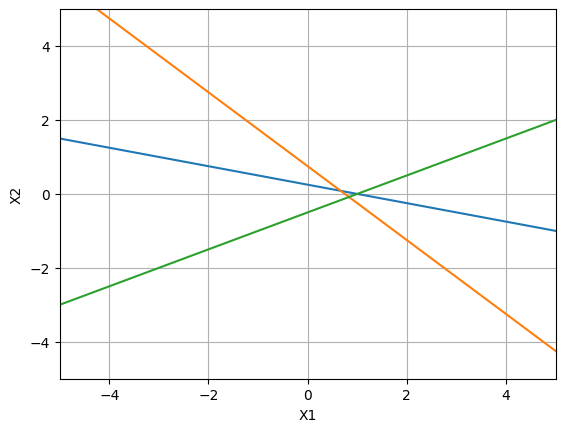

In [249]:
u = np.random.randn(2, 100) 
u = u / np.linalg.norm(u, 2, axis=0)
u_ = B @ u
fig, ax = plt.subplots()
ax.scatter(*u_)
for a_, b_ in zip(A,b):
    plot_hyperplane(ax, a_, b_)

testing max volume ellipsoid

Text(0.5, 1.0, 'polyhedron 2d')

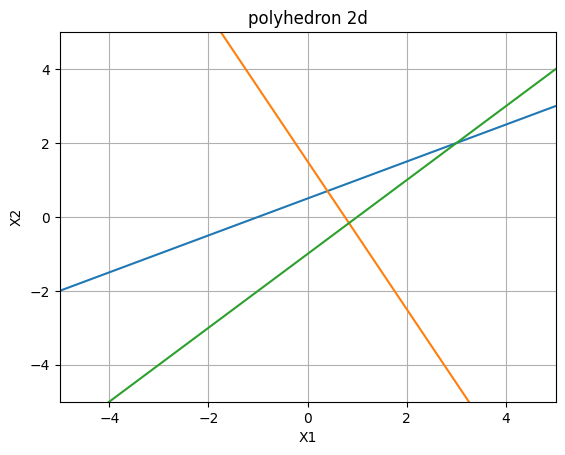

In [253]:

def plot_hyperplane(ax, a_, b_):
    x1 = np.linspace(-5,5,10)
    x2 = (b_ - x1 * a_[0]) / a[1]
    ax.plot(x1, x2)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.grid()


a = np.array([1, 2])
b = 1.5

A = [[-1,2], [4,1], [-2,4]]
b = [1,3, -2]

fig, ax = plt.subplots()
for a_, b_ in zip(A,b):
    plot_hyperplane(ax, a_, b_)
ax.set_title('polyhedron 2d')




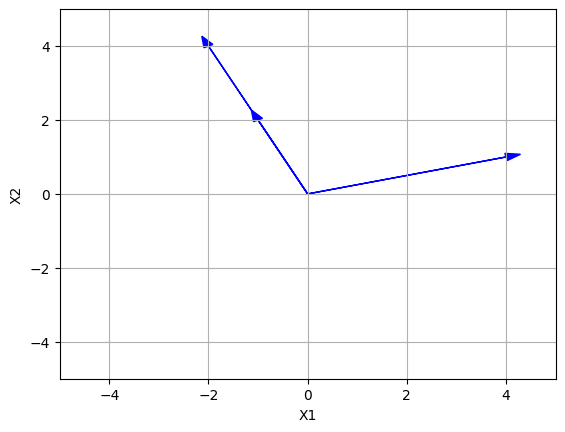

In [251]:
fig, ax = plt.subplots()
for a in A:
    ax.arrow(0, 0, a[0], a[1], head_width=0.2, head_length=0.3, fc='blue', ec='blue')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.grid()

In [5]:
# linear const : [a in Rn, b in Rn] 
polyhedron = [] # list of linear constraints. 


k = 0 
for _ in range(2):
    # choose a point x(k+1) in polydreon
    if polyhedron == []:
    x_k1 = maximum_volume_ellipsoid(polyhedron)
    
    # query the cutting-plane oracle 
    stop, subgradient = cutting_plane_oracle(x_k1)
    
    if stop:
        break
    else:
        polyhedron.append([subgradient, ])
        
    k+=1 

IndentationError: expected an indented block after 'if' statement on line 8 (106023609.py, line 9)

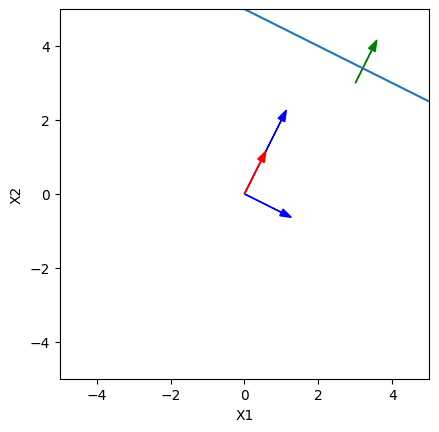

In [267]:
import matplotlib.pyplot as plt 

a = np.array([1, 2])
b = 10

def orthogonal_vec(v):
    v1 =1 
    v2 = -(v[0] * v1) / v[1]
    return np.array([v1,v2])

def unit_vector(v):
    return v / np.linalg.norm(v, ord=2)

orth_a = orthogonal_vec(a)
norm_a = unit_vector(a)

fig, ax = plt.subplots()

plot_hyperplane(ax, a, b)


ax.arrow(0, 0, a[0], a[1], head_width=0.2, head_length=0.3, fc='blue', ec='blue')
ax.arrow(0, 0, orth_a[0], orth_a[1], head_width=0.2, head_length=0.3, fc='blue', ec='blue')
ax.arrow(0, 0, norm_a[0], norm_a[1], head_width=0.2, head_length=0.3, fc='red', ec='red')


# should be azlong a where (a * v) = a.t @ x  
ax.arrow(3, 3, norm_a[0], norm_a[1], head_width=0.2, head_length=0.3, color='green')



ax.plot()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_aspect('equal')
ax.grid()